In [17]:
def confusion_matrix(real, result, num_tests):
    '''
        Create confusion matrix, in this I am considering both directions as true positive
        Number total of tests, indicate the max number of possible tests to calculate true negatives.
    
    '''
    TP = 0
    FN = 0
    
    if real in result:
        TP += 1
    else:
        FN += 1
        
    if real[::-1] in result:
        TP += 1
    else: 
        FN += 1
        
    FP = len(result) - TP
    
    TN = (num_tests - 2) - TP - FN - FP

    return(TP, FP, TN, FN)
    

In [10]:
def confusion_matrix_metrics(confusion_matrix):
    '''
        Calculate simple metrics given a confusion matrix
        
        Accuracy: This is simply equal to the proportion of predictions that the model classified correctly.
        Precision:  also known as positive predictive value and is the proportion of relevant instances 
            among the retrieved instances. In other words, it answers the question 
            “What proportion of positive identifications was actually correct?”
        Recall: also known as the sensitivity, hit rate, or the true positive rate (TPR), is the proportion 
            of the total amount of relevant instances that were actually retrieved. It answers the question 
            “What proportion of actual positives was identified correctly?”
        Specificity: also known as the true negative rate (TNR), measures the proportion of actual negatives 
            that are correctly identified as such. It is the opposite of recall.
        F1 Score: is a measure of a test’s accuracy — it is the harmonic mean of precision and recall. 
            It can have a maximum score of 1 (perfect precision and recall) and a minimum of 0. Overall, 
            it is a measure of the preciseness and robustness of your model.
        -
        Definitions from: https://towardsdatascience.com/understanding-the-confusion-matrix-and-how-to-implement-it-in-python-319202e0fe4d
        -
    '''
        
    TP, FP, TN, FN = confusion_matrix
    
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    
    if TP + FP > 0:
        precision = (TP)/(TP + FP)
    else:
        precision = 0
    
    if TP + FN > 0:
        recall = (TP)/(TP + FN)
    else:
        recall = 0
    
    if TN + FP > 0:
        specificity = (TN)/(TN + FP)
    else:
        specificity = 0
        
    if TP > 0 and TN > 0: #in teory this value never will be zero because you never check desicions when no TP or TN are less than zero, in this case I am assuming that if no TP or TN, abba is totally wrong (f1=0)
        F1_score = (2 * (precision * recall) ) / (precision + recall)
    else:
        F1_score = 0
    
    return accuracy, precision, recall, specificity, F1_score

In [4]:
import random

def generate_tests_from_names(sources, targets_raw, outgroup, no_repeat=True):
    
    if type(sources) is not list:
        sources = [sources]
    
    if type(outgroup) is not list:
        outgroup = [outgroup]
    
    #Declare empty result
    tests =[]
    
    for source in sources:
        #If in sources are the outgroup skip it
        if source in outgroup:
            continue
        
        
        #New unlinked targets list every loop
        targets = targets_raw.copy()
            
        #Remove source and outgroups in case they are repeated in the targets list
        if source in targets:
            targets.remove(source)
        for i in outgroup:
            if i in targets:
                targets.remove(i) 

        #declare empty lists 
        included = []
        

        #Iterate over all targets
        for i, _ in enumerate(targets):
            #empty temp p variables
            p1 = [] 
            p2 = []

           #only do following if target was not already used (not in included)
            if targets[i] not in included:
                #use the first target as p1
                p1 = [targets[i]]
                #mark it is used appending to the list
                if no_repeat: included.append(targets[i])
                #avoid out of boundary errors
                if i < len(targets)-1:
                    #use the next target as p2
                    if targets[i+1] not in included:
                        p2 = [targets[i+1]]
                        #mask it as used
                        if no_repeat: included.append(targets[i+1])
                else:
                    #in case it is the last element (for odd number of targets, use a random one (but the current) as p2)
                    targets.remove(targets[i])
                    p2 =  [random.choice(targets)]

                #append test to the return list
                tests.append({'p1': p1, 'p2': p2, 'p3': [source], 'p4': outgroup})
                
    return tests #return list of dictionaries with every test

In [5]:
import toytree
tips=20
tree = toytree.rtree.baltree(ntips=tips, treeheight=10e6)

source = tree.get_tip_labels()
targets = tree.get_tip_labels()
outgroup = "r19"

tests = generate_tests_from_names(source, targets, outgroup, no_repeat=False)
num_tests = len(tests)

In [6]:
import ast

def get_results_from_file(file):
    '''import results in files'''
    with open(file, "r") as f:
        lines = f.read().splitlines()
    lines = [ast.literal_eval(i) for i in lines]

    return lines


In [7]:
def stats(tests):
    '''get stats individually for each test (not averages)'''
    result = []
    for i in tests:
#         print(tests.index(i))
        cm = confusion_matrix(("r"+i[1],"r"+i[2]), i[3], num_tests)
        cmm = confusion_matrix_metrics(cm)
        result.append([cm, cmm])
    return(result)

In [8]:
import numpy as np

def average_stats(tests):
    '''Make average of confusion matrices and after that calculate metrics for the result'''
    cm =[]
    for i in tests:
        cm.append(confusion_matrix(("r"+i[1],"r"+i[2]), i[3], num_tests))

    cm = np.array(cm)
    cm_mean = cm.mean(0)
    return (cm_mean.tolist(), confusion_matrix_metrics(cm_mean))


## Plots

In [102]:
import toyplot

#get all results for each file
full = get_results_from_file("fulldepur.txt")
nodist = get_results_from_file("f_nodist_depur.txt")
pure = get_results_from_file("pureabbababa.txt")

methodologies = [pure]
names_metrics = ["Accuracy", "Precision", "Recall (TPR)", "Specificity (TNR)", "F1 Score"]


canvas = toyplot.Canvas(800, 500)
markers = []

for i in range(5):
    axes = canvas.cartesian(grid=(2, 3, i), xlabel="Test", ylabel=names_metrics[i], ymax=1)
    for j in methodologies:
        data = [x[1][i] for x in stats(j)]
#         data.sort()
#         data = np.asarray(data)
#         data = data / np.sqrt(np.sum(data**2))
        bars = axes.bars(data, style={"opacity":0.9})
#         bars = axes.bars(np.histogram(data))
        

        markers.append(bars.markers[0])

canvas.legend([
                ("My full filter",markers[0]), 
                ("My filter without distant",markers[1]), 
                ("Pure ABBA-BABA",markers[2])
            ],
            grid=(2, 3, 5)
             )





<svg class="toyplot-canvas-Canvas" height="500.0px" id="t79b8142813c84c80b8b891d82555f721" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 800.0 500.0" width="800.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0 50 100 Test 0.0 0.5 1.0 Accuracy 0 50 100 Test 0.0 0.5 1.0 Precision 0 50 100 Test 0.0 0.5 1.0 Recall (TPR) 0 50 100 Test 0.0 0.5 1.0 Specificity (TNR) 0 50 100 Test 0.0 0.5 1.0 F1 Score My full filter My filter without distant Pure ABBA-BABA

In [96]:
import pandas
#get all results for each file
full = get_results_from_file("fulldepur.txt")
nodist = get_results_from_file("f_nodist_depur.txt")
pure = get_results_from_file("pureabbababa.txt")

# print(average_stats(full)[0])
# print(average_stats(nodist)[0])
# print(average_stats(pure)[0])

names = ["My full filter", "My filter without distant", "Pure ABBA-BABA"]


for i, c in enumerate([full, nodist, pure]):
    TP, FP, TN, FN = average_stats(c)[0]
    print(f"{names[i]} \n TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")

My full filter 
 TP: 1.8333333333333333, FP: 0.6111111111111112, TN: 337.3888888888889, FN: 0.16666666666666666
My filter without distant 
 TP: 1.74, FP: 19.78, TN: 318.22, FN: 0.26
Pure ABBA-BABA 
 TP: 1.84, FP: 97.69, TN: 240.31, FN: 0.16


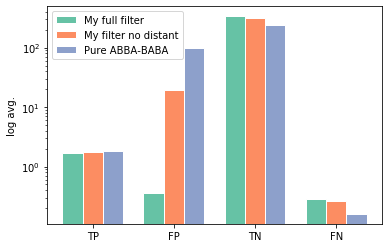

In [99]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
 
# set height of bar

full = get_results_from_file("fulldepur.txt")
nodist = get_results_from_file("f_nodist_depur.txt")
pure = get_results_from_file("pureabbababa.txt")

bars1 = average_stats(full)[0]
bars2 = average_stats(nodist)[0]
bars3 = average_stats(pure)[0]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color="#66c2a5", width=barWidth, edgecolor='white', label='My full filter')
plt.bar(r2, bars2, color='#fc8d62', width=barWidth, edgecolor='white', label='My filter no distant')
plt.bar(r3, bars3, color='#8da0cb', width=barWidth, edgecolor='white', label='Pure ABBA-BABA')
 
# Add xticks on the middle of the group bars
# plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ["TP", "FP", "TN", "FN"])
plt.ylabel("log avg.")

plt.yscale("log")
    
# Create legend & Show graphic
plt.legend()
plt.show()
